In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [2]:
import torch
import numpy as np
import random
import pickle

def seed_everything():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
seed_everything()

## Load dataset

In [3]:
from personalized_nlp.datasets.wiki.aggression import AggressionDataModule
from personalized_nlp.datasets.wiki.attack import AttackDataModule
from personalized_nlp.datasets.wiki.toxicity import ToxicityDataModule
from personalized_nlp.datasets.wiki.aggression_attack import AggressionAttackDataModule

## Import models

In [4]:
from personalized_nlp.models.baseline import Net
from personalized_nlp.models.onehot import NetOneHot
from personalized_nlp.models.human_bias import HumanBiasNet
from personalized_nlp.models.bias import AnnotatorBiasNet
from personalized_nlp.models.annotator import AnnotatorEmbeddingNet
from personalized_nlp.models.annotator_word import AnnotatorWordEmbeddingNet

from personalized_nlp.settings import STORAGE_DIR
from personalized_nlp.learning.train import train_test
from personalized_nlp.utils.metrics import evaluate_classification, evaluate_regression, get_result_dataframe

In [5]:
data_module = AggressionDataModule(embeddings_type='xlmr')

data_module.prepare_data()
data_module.setup()
data_module.compute_word_stats(
    min_word_count=100,
    min_std=0.0, 
    words_per_text=100
)
data_module.annotations

,text_id,annotator_id,aggression,aggression_score,fold
0,37675,1362,1.0,-1.0,8
1,37675,2408,0.0,1.0,0
2,37675,1493,0.0,0.0,2
3,37675,1439,0.0,0.0,8
4,37675,170,0.0,0.0,1
...,...,...,...,...,...
1365212,699897151,628,0.0,0.0,8
1365213,699897151,15,0.0,0.0,3
1365214,699897151,57,0.0,0.0,5
1365215,699897151,1815,0.0,0.0,5


## Evaluate

In [7]:
seed_everything()

results = []
regression=False

for dataset in ['aggression']:
    for embeddings_type in ['bert']:
        
        if dataset == 'attack':
            data_module = AttackDataModule(embeddings_type=embeddings_type)
        elif dataset == 'aggression':
            data_module = AggressionDataModule(embeddings_type=embeddings_type)
        elif dataset =='toxicity':
            data_module = ToxicityDataModule(embeddings_type=embeddings_type)
            
        data_module.prepare_data()
        data_module.setup()
        
        for min_word_count in [100]:#range(100, 320, 20):
            data_module.compute_word_stats(
                min_word_count=min_word_count,
                min_std=0.0, 
                words_per_text=100
            )

            model_type = 'word_embedding'
            embedding_dim = 50

            #pickle.dump(results, open(STORAGE_DIR / 'results/wiki/wiki_word_count_.p', 'wb'))

            for fold_num in range(1):

                hparams = {
                    'dataset': type(data_module).__name__,
                    'model_type': model_type,
                    'embeddings_type': embeddings_type,
                    'embedding_size': embedding_dim,
                    'fold_num': fold_num,
                    'regression': regression,
                    'min_word_count': min_word_count
                }

                output_dim = 2
                text_embedding_dim = data_module.text_embedding_dim
                
                if model_type == 'baseline':
                    model = Net(output_dim=output_dim, text_embedding_dim=text_embedding_dim)
                elif model_type == 'onehot':
                    model = NetOneHot(output_dim=output_dim, annotator_num=data_module.annotators_number, 
                                      text_embedding_dim=text_embedding_dim)
                elif model_type == 'peb':
                    model = HumanBiasNet(output_dim=output_dim, bias_vector_length=len(data_module.class_dims),
                                        text_embedding_dim=text_embedding_dim)
                elif model_type == 'bias':
                    model = AnnotatorBiasNet(output_dim=output_dim, text_embedding_dim=text_embedding_dim, 
                                             word_num=data_module.words_number,
                                             annotator_num=data_module.annotators_number)
                elif model_type == 'embedding':
                    model = AnnotatorEmbeddingNet(output_dim=output_dim, text_embedding_dim=text_embedding_dim, 
                                                  word_num=data_module.words_number, 
                                                  annotator_num=data_module.annotators_number, dp=0.0, dp_emb=0.25, 
                                                  embedding_dim=embedding_dim, hidden_dim=100)
                elif model_type == 'word_embedding':
                    model = AnnotatorWordEmbeddingNet(output_dim=output_dim, text_embedding_dim=text_embedding_dim, 
                                                      word_num=data_module.words_number, 
                                                      annotator_num=data_module.annotators_number, dp=0.0, dp_emb=0.25,
                                                      embedding_dim=embedding_dim, hidden_dim=100)
                
                test_predictions, true_labels, model, timings = train_test(data_module, model, epochs=15, lr=0.008, regression=regression,
                                                                  use_cuda=True)

                result_metrics = evaluate_classification(test_predictions, 
                                                         true_labels, 
                                                         class_dims=data_module.class_dims)

                result_metrics['training_time'] = timings['training_time']
                result_metrics['testing_time'] = timings['testing_time']

                results.append((hparams, result_metrics))

wandb: Currently logged in as: satyrr (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | AnnotatorWordEmbeddingNet | 8.9 M 
1 | metrics | ModuleDict                | 0     
------------------------------------------------------
8.9 M     Trainable params
0         Non-trainable params
8.9 M     Total params
35.479    Total estimated model params size (MB)


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy_a': 0.893592894077301,
 'test_f1_a': 0.6694098711013794,
 'test_loss': 0.2621415853500366,
 'test_macro_f1_a': 0.8030008673667908,
 'test_precision_a': 0.8212884068489075,
 'test_recall_a': 0.5649375915527344}
--------------------------------------------------------------------------------



TypeError: cannot unpack non-iterable NoneType object

## Word Embeddings visualization

In [6]:
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set_context('talk')

In [9]:
offensive_words_idx = data_module.word_stats.index.tolist()

In [10]:
X = model.word_embeddings(torch.tensor(offensive_words_idx).to('cpu')).cpu().detach().numpy()

In [11]:
X_embedded = TSNE(n_components=2, learning_rate=200, perplexity=50).fit_transform(X)
X_embedded.shape

(4019, 2)

In [12]:

df = pd.DataFrame()#data.loc[data.split == 'test'].iloc[:2000].copy()

df['x_0'] = X_embedded[:, 0]
df['x_1'] = X_embedded[:, 1]
df['word'] = [data_module.idx_to_word[i] for i in offensive_words_idx]
df['mean'] = data_module.word_stats['mean'].values
df['std'] = data_module.word_stats['std'].values
#df['entropy'] = data_module.word_stats['entropy'].values
df['word_count'] = data_module.word_stats['word_count'].values
df['word_count_log'] = np.log(data_module.word_stats['word_count'].values)


<AxesSubplot:>

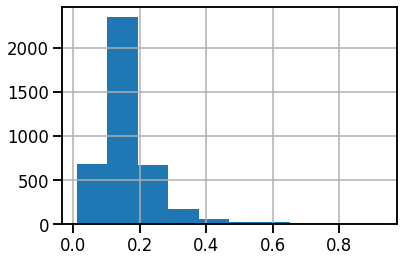

In [13]:
df['mean'].hist()

In [14]:
df.to_csv('./data/wiki_embeddings_visualization/aggressive_words.csv')

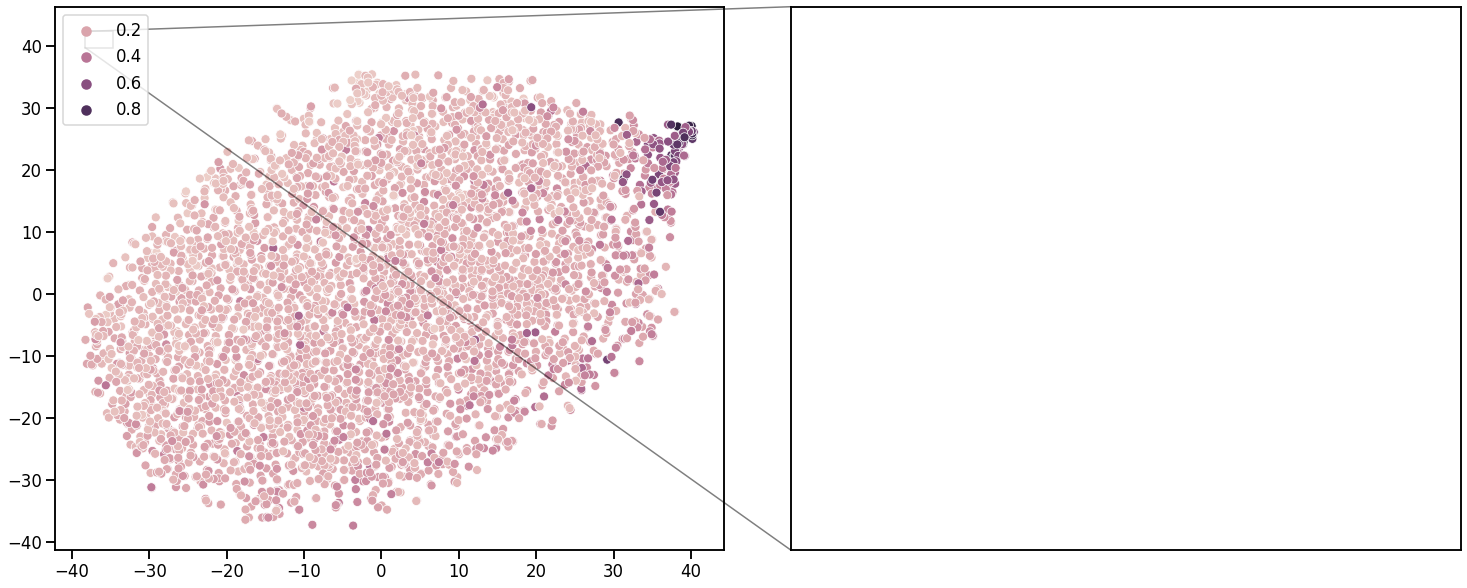

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(12, 10))
ax = fig.gca()


axins = ax.inset_axes([1.1, 0.0, 1, 1])

sns.scatterplot(data=df, x="x_0", y="x_1", hue='mean')
g = sns.scatterplot(data=df, x="x_0", y="x_1", hue='mean', ax=axins, legend=False)

inset_x_min = -38
inset_x_max = -35

inset_y_min = 40
inset_y_max = 42


axins.set_xlim((inset_x_min,inset_x_max))
axins.set_ylim((inset_y_min,inset_y_max))

ax.set_ylabel(None)
ax.set_xlabel(None)
#ax.set_xticks([])
#ax.set_yticks([])

axins.set_ylabel(None)
axins.set_xlabel(None)
axins.set_xticks([])
axins.set_yticks([])

axins.set_ylim((inset_y_min-0.3, inset_y_max+0.3))
axins.set_xlim((inset_x_min-0.3, inset_x_max+0.3))

plt.legend(loc='upper left')

for i, point in df.iterrows():
    if point['x_0'] > inset_x_max or point['x_0'] < inset_x_min:
        continue
    if point['x_1'] > inset_y_max or point['x_1'] < inset_y_min:
        continue
    
    axins.text(point['x_0']+.02, point['x_1'], str(point['word']))
        
ax.indicate_inset_zoom(axins, edgecolor="black")
#plt.show()
#plt.autoscale()
plt.savefig('word_embeddings_mean.pdf', dpi=300, bbox_inches='tight')  


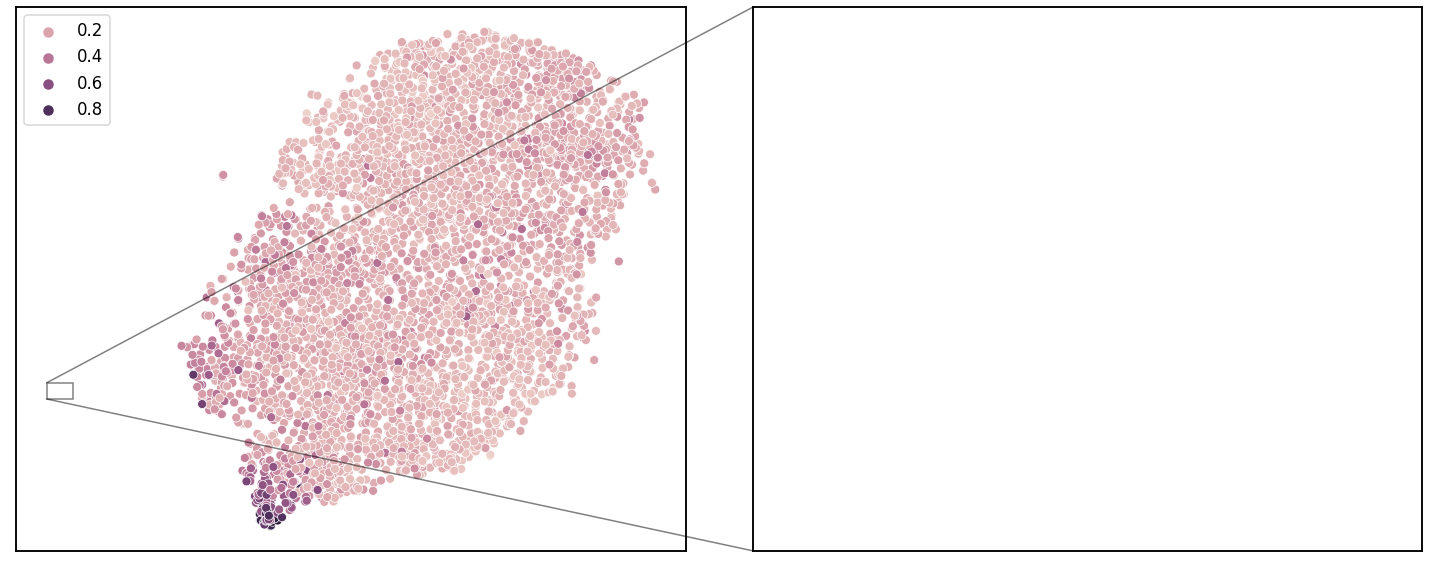

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(12, 10))
ax = fig.gca()


axins = ax.inset_axes([1.1, 0.0, 1, 1])

sns.scatterplot(data=df, x="x_0", y="x_1", hue='mean')
g = sns.scatterplot(data=df, x="x_0", y="x_1", hue='mean', ax=axins, legend=False)

inset_x_min = -51
inset_x_max = -48

inset_y_min = -27
inset_y_max = -24


axins.set_xlim((inset_x_min,inset_x_max))
axins.set_ylim((inset_y_min,inset_y_max))

ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_xticks([])
ax.set_yticks([])

axins.set_ylabel(None)
axins.set_xlabel(None)
axins.set_xticks([])
axins.set_yticks([])

axins.set_ylim((inset_y_min-0.3, inset_y_max+0.3))
axins.set_xlim((inset_x_min-0.3, inset_x_max+0.3))

plt.legend(loc='upper left')

for i, point in df.iterrows():
    if point['x_0'] > inset_x_max or point['x_0'] < inset_x_min:
        continue
    if point['x_1'] > inset_y_max or point['x_1'] < inset_y_min:
        continue
    
    axins.text(point['x_0']+.02, point['x_1'], str(point['word']))
        
ax.indicate_inset_zoom(axins, edgecolor="black")
#plt.show()
#plt.autoscale()
plt.savefig('word_embeddings_mean.pdf', dpi=300, bbox_inches='tight')  


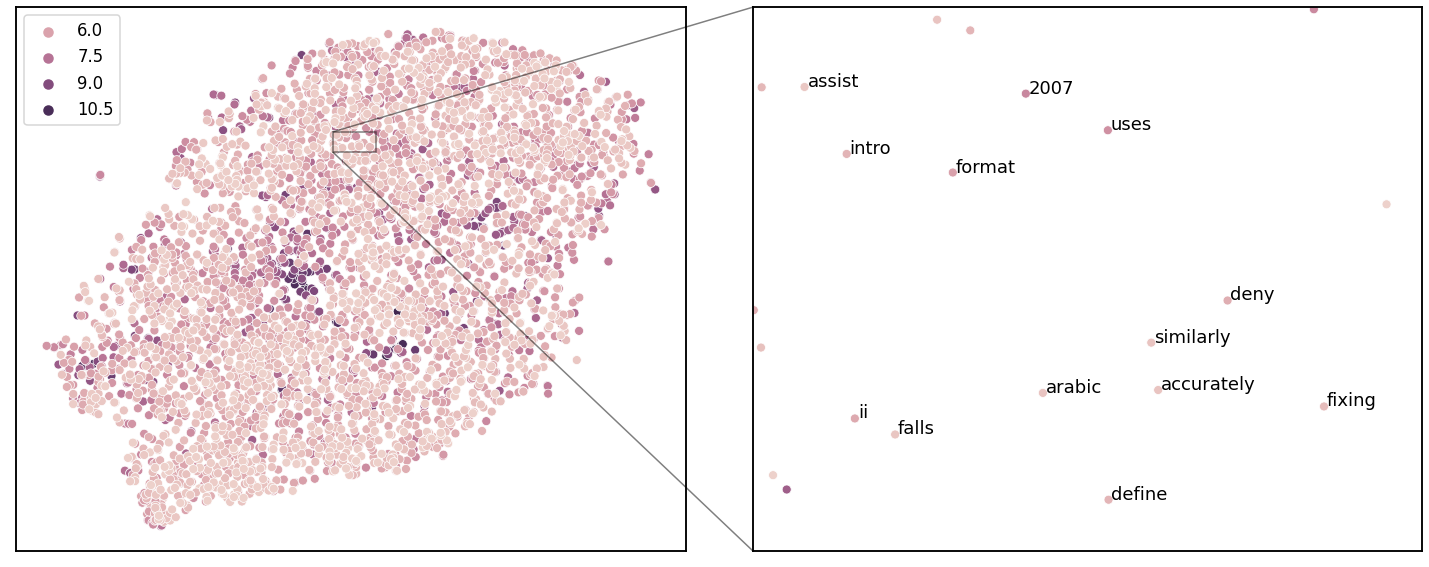

In [16]:
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(12, 10))
ax = fig.gca()


axins = ax.inset_axes([1.1, 0.0, 1, 1])

sns.scatterplot(data=df, x="x_0", y="x_1", hue='word_count_log')
g = sns.scatterplot(data=df, x="x_0", y="x_1", hue='word_count_log', ax=axins, legend=False)

inset_x_min = -2
inset_x_max = 2

inset_y_min = 28
inset_y_max = 32


axins.set_xlim((inset_x_min,inset_x_max))
axins.set_ylim((inset_y_min,inset_y_max))

ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_xticks([])
ax.set_yticks([])

axins.set_ylabel(None)
axins.set_xlabel(None)
axins.set_xticks([])
axins.set_yticks([])

axins.set_ylim((inset_y_min-0.3, inset_y_max+0.3))
axins.set_xlim((inset_x_min-0.3, inset_x_max+0.3))

plt.legend(loc='upper left')

for i, point in df.iterrows():
    if point['x_0'] > inset_x_max or point['x_0'] < inset_x_min:
        continue
    if point['x_1'] > inset_y_max or point['x_1'] < inset_y_min:
        continue
    
    axins.text(point['x_0']+.02, point['x_1'], str(point['word']))
        
ax.indicate_inset_zoom(axins, edgecolor="black")
#plt.show()
#plt.autoscale()
plt.savefig('word_embeddings_word_count.pdf', dpi=300, bbox_inches='tight')  


In [26]:
fig = px.scatter(df, x="x_0", y="x_1", hover_data=['word'], color='word_count')

fig.update_traces(marker=dict(
        color = np.log(df['word_count']),
        showscale=True,
        colorscale = 'RdBu'
    ))

#fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['x', 'y', 'mean', 'std', 'count'] but received: x_0

## Annotator embeddings visualization

In [16]:
model_annotator_embeddings = model.annotator_embeddings.weight.data.cpu().numpy()[1:]
model_annotator_embeddings.shape

tsne = TSNE(2)
annotator_embeddings_2d = tsne.fit_transform(model_annotator_embeddings)

In [17]:
annotators_embeddings_df = pd.DataFrame(annotator_embeddings_2d)
annotators_embeddings_df.columns = ['x', 'y']
annotators_embeddings_df['annotator_id'] = data_module.annotator_biases.index.values

In [18]:
annotations_df = data_module.annotations

In [19]:
annotator_stats = annotations_df.groupby('annotator_id').agg(['mean', 'std', 'count']).fillna(0).reset_index()
annotator_stats.columns = annotator_stats.columns.map('_'.join)
annotator_stats['annotator_id'] = annotator_stats['annotator_id_']
annotators_embeddings_df = annotators_embeddings_df.merge(annotator_stats, on='annotator_id')

In [20]:
annotations_counts = annotations_df.annotator_id.value_counts().reset_index()
annotations_counts.columns = ['annotator_id_', 'total_count']

annotators_embeddings_df = annotators_embeddings_df.merge(annotations_counts)

In [21]:
annotators_embeddings_df.to_csv('./data/wiki_embeddings_visualization/aggressive_annotators.csv')

In [7]:
import pandas as pd
annotators_embeddings_df = pd.read_csv('./data/wiki_embeddings_visualization/aggressive_annotators.csv').iloc[:, 1:]
annotators_embeddings_df

,x,y,annotator_id,annotator_id_,text_id_mean,text_id_std,text_id_count,aggression_mean,aggression_std,aggression_count,aggression_score_mean,aggression_score_std,aggression_score_count,fold_mean,fold_std,fold_count,total_count
0,-9.349627,45.573196,0,0,3.025472e+08,1.988254e+08,1023,0.353861,0.478401,1023,-0.461388,0.894769,1023,9,0.0,1023,1023
1,-16.158064,-50.877842,1,1,3.102663e+08,2.058455e+08,814,0.113022,0.316814,814,-0.092138,0.498571,814,9,0.0,814,814
2,36.541428,-9.242048,2,2,2.928790e+08,1.933282e+08,450,0.084444,0.278363,450,0.000000,0.629632,450,1,0.0,450,450
3,-5.742120,-42.511760,3,3,3.065728e+08,2.011775e+08,1035,0.087923,0.283319,1035,-0.050242,0.604134,1035,8,0.0,1035,1035
4,-5.500489,-39.165794,4,4,3.019653e+08,1.955487e+08,934,0.132762,0.339499,934,-0.233405,0.692261,934,1,0.0,934,934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,19.716280,28.527573,4048,4048,3.284989e+08,2.478698e+08,9,0.555556,0.527046,9,-0.777778,1.201850,9,3,0.0,9,9
4049,19.712133,28.522630,4049,4049,1.927675e+08,0.000000e+00,1,0.000000,0.000000,1,0.000000,0.000000,1,7,0.0,1,1
4050,19.715786,28.524775,4050,4050,5.530678e+08,0.000000e+00,1,0.000000,0.000000,1,0.000000,0.000000,1,5,0.0,1,1
4051,19.714060,28.527483,4051,4051,3.530099e+08,2.343644e+08,9,0.777778,0.440959,9,-0.888889,0.927961,9,9,0.0,9,9


<Figure size 864x720 with 0 Axes>

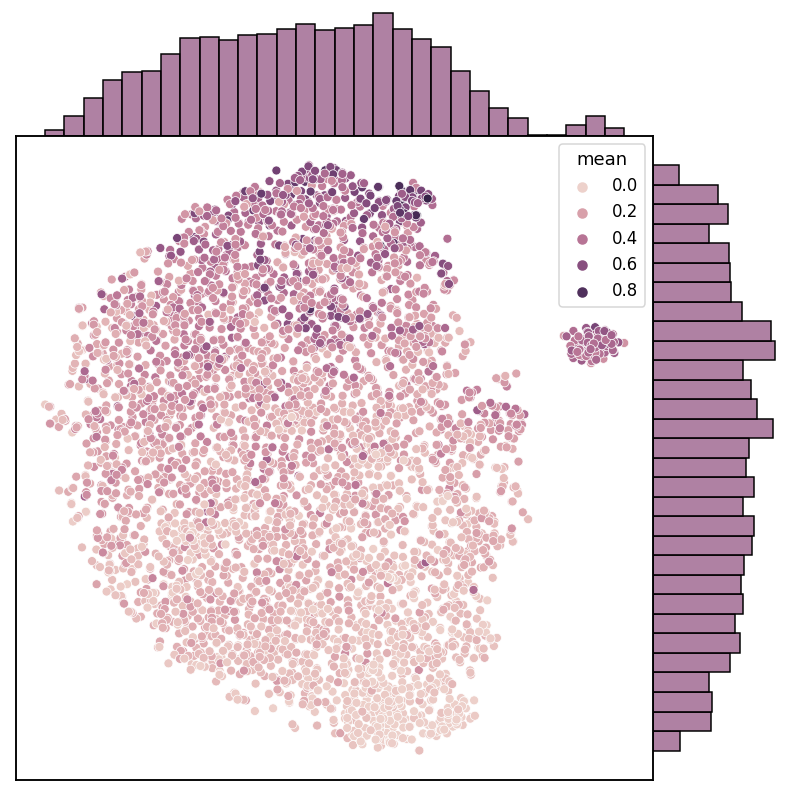

<Figure size 864x720 with 0 Axes>

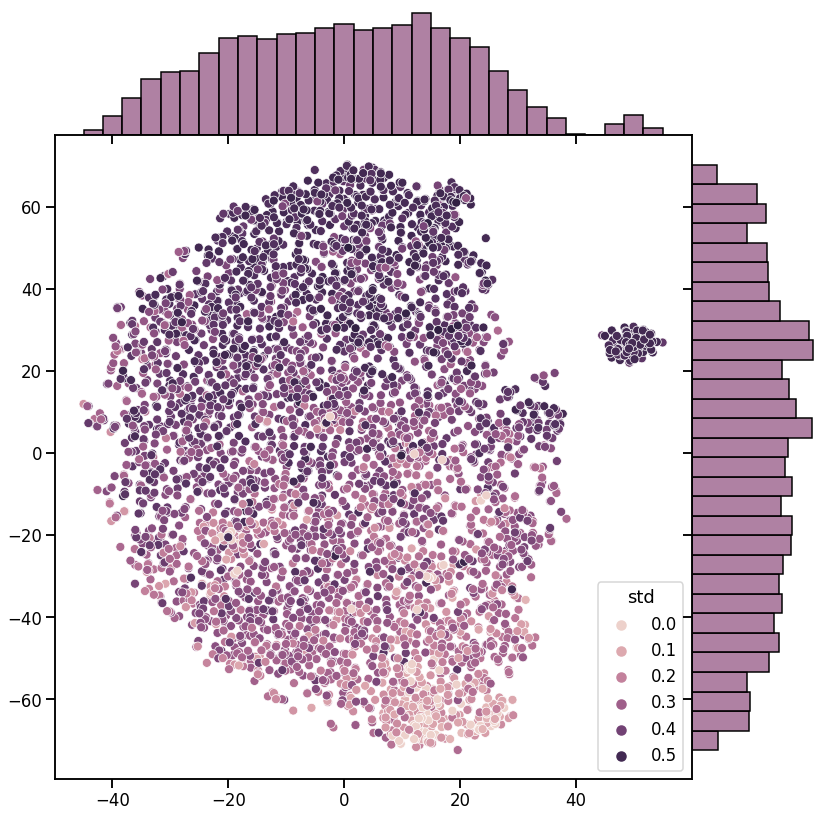

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("talk")

plt.figure(figsize=(12,10))
#df = annotators_embeddings_df.loc[:, ['x', 'y', 'attack_mean', 'attack_std', 'total_count']]
df = annotators_embeddings_df.loc[:, ['x', 'y', 'aggression_mean', 'aggression_std', 'aggression_count']]

df.columns = ['x', 'y', 'mean', 'std', 'count']
#df = df[df['count'] > 200]
#df = df[(df.x > -60) & (df.x < -30) & (df.y > 30) & (df.y < 50)] 

g = sns.JointGrid(data=df, x="x", y="y", height=12, space=0)
sns.scatterplot(data=df, x="x", y="y", hue='mean', ax=g.ax_joint)
g.ax_joint.set_xticks([])
g.ax_joint.set_yticks([])
g.ax_joint.set_xlabel('')
g.ax_joint.set_ylabel('')

sns.histplot(data=df, x="x", kde=False, color=sns.cubehelix_palette()[3], ax=g.ax_marg_x, bins=30)
sns.histplot(data=df, y="y", kde=False, color=sns.cubehelix_palette()[3], ax=g.ax_marg_y, bins=30)

plt.savefig('annotator_embeddings_mean.pdf', dpi=300)
plt.show()

plt.figure(figsize=(12,10))

g = sns.JointGrid(data=df, x="x", y="y", height=12, space=0)
sns.scatterplot(data=df, x="x", y="y", hue='std', ax=g.ax_joint)
#g.ax_joint.set_xticks([])
#g.ax_joint.set_yticks([])
g.ax_joint.set_xlabel('')
g.ax_joint.set_ylabel('')

sns.histplot(data=df, x="x", kde=False, color=sns.cubehelix_palette()[3], ax=g.ax_marg_x, bins=30)
sns.histplot(data=df, y="y", kde=False, color=sns.cubehelix_palette()[3], ax=g.ax_marg_y, bins=30)

plt.savefig('annotator_embeddings_std.pdf', dpi=300)

In [12]:
ann_ids = df[(df.x > 40) & (df.x < 100)].index.tolist()
ann_ids2 = df[(df.x > 10) & (df.x < 20) & (df.y > 50) & (df.y < 60)].index.tolist()
#ann_ids = df[(df.x > 40) & (df.x < 100) & (df.y > 30) & (df.y < 60)].index.tolist()

In [13]:
annotations_df = data_module.annotations_with_data
strange_annotators_df = annotations_df[annotations_df.annotator_id.isin(ann_ids)]
strange_annotators_df2 = annotations_df[annotations_df.annotator_id.isin(ann_ids2)]

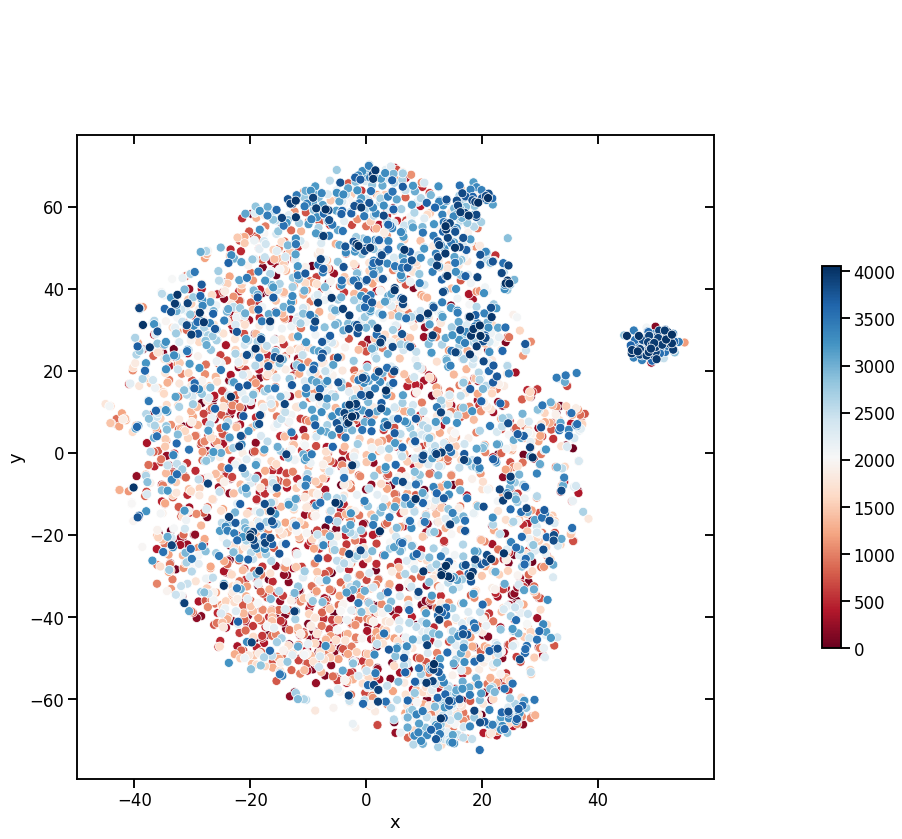

In [14]:
df['annotator_id'] = annotators_embeddings_df['annotator_id'].astype('float')

cmap = sns.cubehelix_palette(as_cmap=True)
g = sns.JointGrid(data=df, x="x", y="y", height=12, space=0)
ax = sns.scatterplot(data=df, x="x", y="y", hue='annotator_id', ax=g.ax_joint, palette='RdBu')

norm = plt.Normalize(df['annotator_id'].min(), df['annotator_id'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)


<AxesSubplot:>

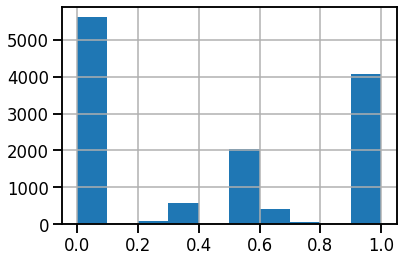

In [15]:
strange_annotators_df.groupby('text_id')['aggression'].mean().hist()

(0.0, 100.0)

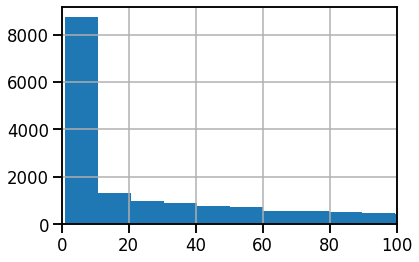

In [16]:
differences = np.array(strange_annotators_df.index.tolist() + [0])[1:] - np.array(strange_annotators_df.index.tolist())
pd.Series(differences[:-1]).hist(bins=100)
plt.xlim(0, 100)

(0.0, 100.0)

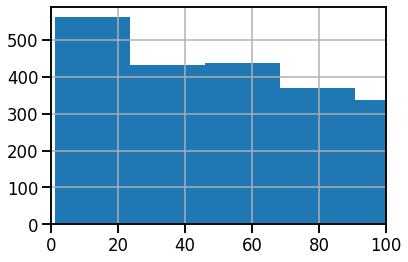

In [17]:
differences = np.array(strange_annotators_df2.index.tolist() + [0])[1:] - np.array(strange_annotators_df2.index.tolist())
pd.Series(differences[:-1]).hist(bins=100)
plt.xlim(0, 100)

<AxesSubplot:>

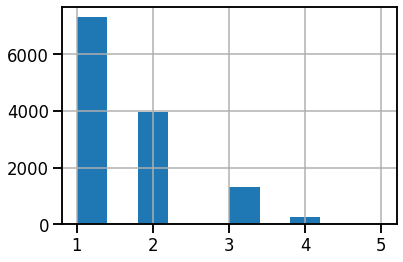

In [18]:
strange_annotators_df.text_id.value_counts().hist()

In [25]:
strange_annotators_df.text_id.value_counts().std()

0.7711068189811033

In [27]:
strange_annotators_df2.text_id.value_counts().std()

0.18773878092816568

<AxesSubplot:>

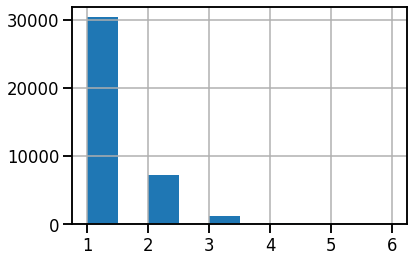

In [20]:
annotations_df[annotations_df.annotator_id.isin(annotations_df.annotator_id.sample(n=81))].text_id.value_counts().hist()

<AxesSubplot:>

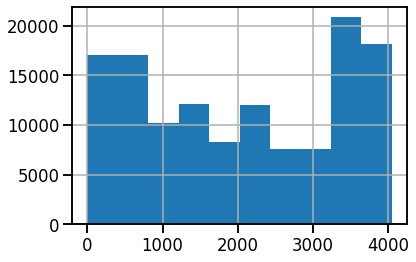

In [21]:
annotations_df[annotations_df.text_id.isin(strange_annotators_df.text_id)].annotator_id.hist()

<AxesSubplot:>

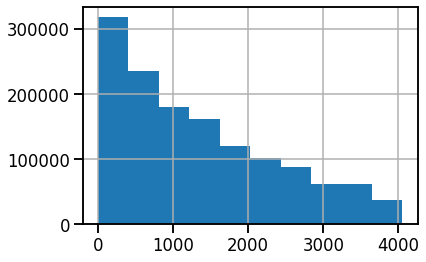

In [22]:
annotations_df.annotator_id.hist()

In [23]:
data_module.annotators[data_module.annotators.annotator_id.isin(ann_ids2)]

,annotator_id,gender,english_first_language,age_group,education
65,3173,female,0,30-45,professional
356,2580,female,0,30-45,masters
432,3356,male,0,45-60,professional
544,3660,male,0,30-45,bachelors
600,3485,female,0,45-60,bachelors
646,2084,female,0,18-30,hs
647,3807,male,1,45-60,masters
750,4012,female,0,30-45,masters
830,2954,male,0,18-30,masters
949,1940,male,0,18-30,bachelors
